In [29]:
import sys, os
import numpy as np
from pyhdf.SD import SD
import pandas as pd
from datetime import datetime, time, timedelta
import re
import time
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import pearsonr

from functions import *
# Path and Variable declarations
# External harddrive path
file_ext= "D:\\NASA_AIRS"
file_path_plots=r"C:\Users\Zelda64\Documents\Programming\dust_solar_power\Plots"
# Internal testing folder
#file_ext=r"C:\Users\Zelda64\Documents\Programming\dust_solar_power\AIRS"
#sort file list

folder_year_list=sorted(os.listdir(file_ext))


# Coordinates for TECQ stations
CAMS49 = [31.6676,-106.288]
CAMS1028 = [33.5856, -101.78]


In [30]:
'''
# File names for TECQ PM2.5 stations in West Texas
file_name_cams49=r'CAMS49_2019.xlsx'
file_name_cams1028=r'CAMS1028_2020.xlsx'
# Read both TECQ files into dataframes
tecq_cams49 = read_xlsx_tecq(file_name_cams49)
tecq_cams1028= read_xlsx_tecq(file_name_cams1028)
#tecq_cams49.info()
tecq_cams49
tecq_cams1028
'''

"\n# File names for TECQ PM2.5 stations in West Texas\nfile_name_cams49=r'CAMS49_2019.xlsx'\nfile_name_cams1028=r'CAMS1028_2020.xlsx'\n# Read both TECQ files into dataframes\ntecq_cams49 = read_xlsx_tecq(file_name_cams49)\ntecq_cams1028= read_xlsx_tecq(file_name_cams1028)\n#tecq_cams49.info()\ntecq_cams49\ntecq_cams1028\n"

In [33]:
'''
def open_hdf4_files():
    """
    Open list of AIRS HDF4 files and read dust_score, latitude, longitude and run 
    other functions to work with them.
    
    Parameters:
        file_list (list): List of file paths to HDF4 files.
    """
'''
dust_score_pm_matches_cams49=[['PM', 'dust_score']]
dust_score_pm_matches_max_cams49=[['PM', 'dust_score']]
dust_score_pm_matches_cams1028=[['PM', 'dust_score']]
dust_score_pm_matches_max_cams1028=[['PM', 'dust_score']]


for year in folder_year_list:
    start_time=time.time()
    file_path_ext=os.path.join(file_ext,year)
    file_list=sorted(os.listdir(os.path.join(file_ext,file_path_ext)))[1:]
    print("Opening folder:", file_path_ext)
    dust_score_pm_matches_cams49.append([year, year])
    dust_score_pm_matches_max_cams49.append([year, year])
    dust_score_pm_matches_cams1028.append([year, year])
    dust_score_pm_matches_max_cams1028.append([year, year])
    
    file_name_cams49=f'CAMS49_{year}.xlsx'
    file_name_cams1028=f'CAMS1028_{year}.xlsx'
    tecq_cams49=read_xlsx_tecq(file_name_cams49)
    tecq_cams1028=read_xlsx_tecq(file_name_cams1028)
    for file in file_list:
        file_path=os.path.join(file_path_ext,file)
        print("Opening file:", file_path)
        
        try:
            hdf_file = SD(file_path)
    
            # Select dust_score, lat and long     
            dust_score=hdf_file.select('dust_score')[:]
            long=hdf_file.select('Longitude')[:]
            lat=hdf_file.select('Latitude')[:]
            coords=coordinates(lat,long)
            # Find timestamp of production
            global_attributes = hdf_file.attributes()
            # Get raw productiondatetime from hdf file
            datetime_hdf_raw=find_rangedatetime(global_attributes)

            # Convert raw string into datetime object
            datetime_converted=datetime.strptime(datetime_hdf_raw,"%Y-%m-%dT%H:%M:%S.%fZ")

            # Round time from converted hdf datetime object to nearest hour 
            datetime_rounded_time=round_nearest_hour(datetime_converted)

                
            print("UTC: ",datetime_rounded_time)
            # Convert UTC to MST (only valid for CAMS49)
            datetime_rounded_time_mst=datetime_rounded_time-timedelta(hours=7)
            datetime_rounded_time_cst=datetime_rounded_time-timedelta(hours=6)
            print("MST: ",datetime_rounded_time_mst)
            print("CST: ",datetime_rounded_time_cst)

            # Convert datetime object (date part only) into string
            datetime_converted_str_mst=datetime_rounded_time_mst.date().strftime("%Y-%m-%d")
            datetime_converted_str_cst=datetime_rounded_time_cst.date().strftime("%Y-%m-%d")
            
            # Use the date string to find the matching date row in the TECQ file
            tecq_date_found_cams49=tecq_cams49.loc[datetime_converted_str_mst]
            tecq_date_found_cams1028=tecq_cams1028.loc[datetime_converted_str_cst]
            
            # Make an array of an hour before and after the flyby's rounded hour
            datetime_range_mst=[(datetime_rounded_time_mst-timedelta(hours=1)).time(), (datetime_rounded_time_mst.time()), (datetime_rounded_time_mst+timedelta(hours=1)).time()]
            datetime_range_cst=[(datetime_rounded_time_cst-timedelta(hours=1)).time(), (datetime_rounded_time_cst.time()), (datetime_rounded_time_cst+timedelta(hours=1)).time()]
            # Find the mean PM concentration at time of satellite flyby at TECQ station
            tecq_pm_hourmean_cams49=np.mean(tecq_date_found_cams49[datetime_range_mst])
            tecq_pm_hourmean_cams1028=np.mean(tecq_date_found_cams1028[datetime_range_cst])
            # Find the max daily PM at TECQ station   
            tecq_pm_daymax_cams49=np.max(tecq_date_found_cams49)
            tecq_pm_daymax_cams1028=np.max(tecq_date_found_cams1028)
            print("Mean 3hour PM CAMS49: ", tecq_pm_hourmean_cams49)
            print("Max Daily PM CAMS49: ", tecq_pm_daymax_cams49)
            print("Mean 3hour PM CAMS49: ", tecq_pm_hourmean_cams1028)
            print("Max Daily PM CAMS49: ", tecq_pm_daymax_cams1028)
                
            # Match coordinates between satellite flyby and TECQ stations
            matched_cams49_coords=match_coords(coords, CAMS49)
            matched_cams1028_coords=match_coords(coords, CAMS1028)
            # Create boolean mask for each array of matched coordinates
            mask_cams49=create_mask(matched_cams49_coords)
            mask_cams1028=create_mask(matched_cams1028_coords)
            # Check if any mask is only False boolean values
            anymatches1028=np.any(mask_cams1028 == True, axis=1)
            anymatches49=np.any(mask_cams49 == True, axis=1)
            # Do not process coordinates if they do not match for either TECQ station
            if np.any(anymatches1028 == True, axis=0):
                print("Found matching coordinates for CAMS1028...")
                dust_score_masked_cams1028=dust_score[mask_cams1028]
                dust_score_mean_cams1028=np.mean(dust_score_masked_cams1028)
                dust_score_max_cams1028=np.max(dust_score_masked_cams1028)
                print("Mean dust_score CAMS1028: ",dust_score_mean_cams1028)
                print("Max dust_score CAMS1028: ",dust_score_max_cams1028)
                dust_score_pm_matches_cams1028.append([tecq_pm_hourmean_cams1028, dust_score_mean_cams1028])
                dust_score_pm_matches_max_cams1028.append([tecq_pm_daymax_cams1028, dust_score_max_cams1028])
            else:
                print("No matching coordinates found for CAMS1028.")

            if np.any(anymatches49 == True, axis=0):
                print("Found matching coordinates for CAMS49...")
                dust_score_masked_cams49=dust_score[mask_cams49]
                dust_score_mean_cams49=np.mean(dust_score_masked_cams49)
                dust_score_max_cams49=np.max(dust_score_masked_cams49)
                print("Mean dust_score CAMS49: ",dust_score_mean_cams49)
                print("Max dust_score CAMS49: ",dust_score_max_cams49)               
                dust_score_pm_matches_cams49.append([tecq_pm_hourmean_cams49, dust_score_mean_cams49])
                dust_score_pm_matches_max_cams49.append([tecq_pm_daymax_cams49, dust_score_max_cams49])
            else:
                print("No matching coordinates found for CAMS49.")

            '''
                if dust_score_max>380:
                    print("Found dust_score above 380, printing plot...")
                    draw_grid_plot(coords, coords_masked, file, datetime_hdf_raw, dust_score)
                '''
            print("\n")
            # Close the HDF4 file
            hdf_file.end()
        except Exception as e:
            print("Error opening file:", file_path)
            print(e)
            print("\n")
    end_time=time.time()
    runtime = end_time - start_time
    print("Execution time per year:", runtime, "sec")
'''
if __name__ == "__main__":
    # Array of matched PM to dust_score
    
    # Open HDF4 files
    open_hdf4_files()
'''

Opening folder: D:\NASA_AIRS\2019
Opening file: D:\NASA_AIRS\2019\AIRS.2019.01.01.098.L1B.AIRS_Rad.v5.0.23.0.G19001113440.hdf
UTC:  2019-01-01 10:00:00
MST:  2019-01-01 03:00:00
CST:  2019-01-01 04:00:00
Mean 3hour PM CAMS49:  34.53333333333333
Max Daily PM CAMS49:  41.1
Mean 3hour PM CAMS49:  3.3333333333333335
Max Daily PM CAMS49:  7.0
No matching coordinates found for CAMS1028.
Found matching coordinates for CAMS49...
Mean dust_score CAMS49:  64.36507936507937
Max dust_score CAMS49:  294


Opening file: D:\NASA_AIRS\2019\AIRS.2019.01.01.192.L1B.AIRS_Rad.v5.0.23.0.G19002100753.hdf
UTC:  2019-01-01 20:00:00
MST:  2019-01-01 13:00:00
CST:  2019-01-01 14:00:00
Mean 3hour PM CAMS49:  1.5666666666666667
Max Daily PM CAMS49:  41.1
Mean 3hour PM CAMS49:  2.0
Max Daily PM CAMS49:  7.0
Found matching coordinates for CAMS1028...
Mean dust_score CAMS1028:  144.03333333333333
Max dust_score CAMS1028:  356
No matching coordinates found for CAMS49.


Opening file: D:\NASA_AIRS\2019\AIRS.2019.01.01

'\nif __name__ == "__main__":\n    # Array of matched PM to dust_score\n    \n    # Open HDF4 files\n    open_hdf4_files()\n'

In [54]:
print(len(dust_score_pm_matches_cams49))
print(len(dust_score_pm_matches_max_cams49))
print(len(dust_score_pm_matches_cams1028))
print(len(dust_score_pm_matches_max_cams1028))

1730
1730
1713
1713


(22, 2)
(28, 2)


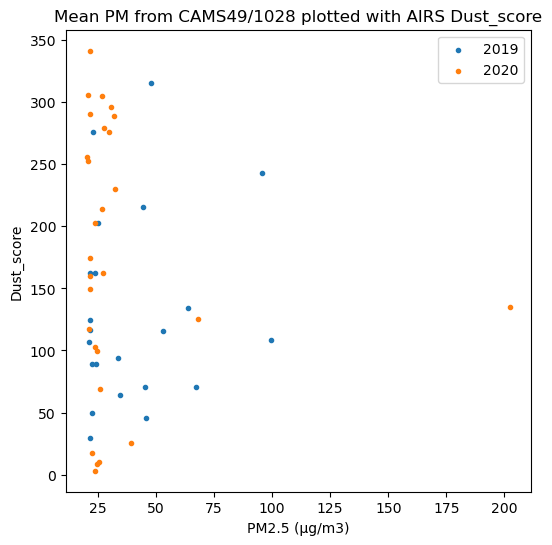

Pearson correlation coefficient 2019 data: 0.147
p-value: 0.513
Pearson correlation coefficient 2020 data: -0.099
p-value: 0.616
Pearson correlation coefficient 2019 and 2020 data: -0.055
p-value: 0.702


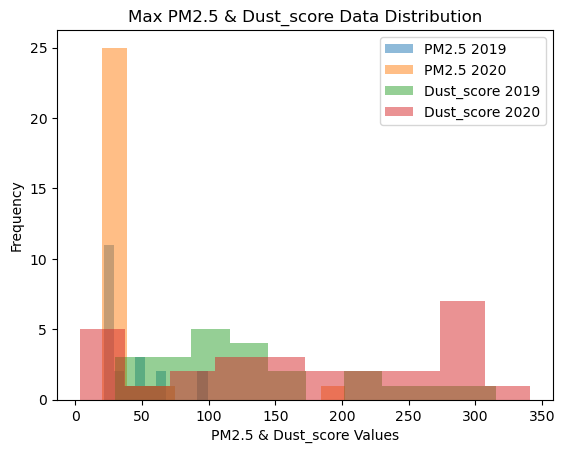

In [140]:
def plot_dust_pm(type: str, threshold_pm: int, threshold_dust_score: int, dust_score_pm_matches_array: list, additional_array: list = None):
    index_year_2019=dust_score_pm_matches_array.index(['2019', '2019'])
    index_year_2020=dust_score_pm_matches_array.index(['2020', '2020'])

    dust_score_pm_matches_2019=np.array(dust_score_pm_matches_array[index_year_2019+1:index_year_2020])
    dust_score_pm_matches_2020=np.array(dust_score_pm_matches_array[index_year_2020+1:])

    if additional_array is not None:
        
        index_year_2019_add=additional_array.index(['2019', '2019'])
        index_year_2020_add=additional_array.index(['2020', '2020'])
        additional_array_2019=np.array(additional_array[index_year_2019_add+1:index_year_2020_add])
        additional_array_2020=np.array(additional_array[index_year_2020_add+1:]) 
        dust_score_pm_matches_2019=np.concatenate((dust_score_pm_matches_2019,additional_array_2019), axis=0)
        dust_score_pm_matches_2020=np.concatenate((dust_score_pm_matches_2020,additional_array_2020), axis=0)

    mask_matches_2019=np.isnan(dust_score_pm_matches_2019).any(axis=1)
    mask_matches_2020=np.isnan(dust_score_pm_matches_2020).any(axis=1)
    
    dust_score_pm_matches_2019=dust_score_pm_matches_2019[~mask_matches_2019]
    dust_score_pm_matches_2020=dust_score_pm_matches_2020[~mask_matches_2020]
    
    dust_score_pm_matches_2020_filtered=dust_score_pm_matches_2020[np.logical_and(dust_score_pm_matches_2020[:,0]>threshold_pm, dust_score_pm_matches_2020[:,1]>threshold_dust_score)]
    dust_score_pm_matches_2019_filtered=dust_score_pm_matches_2019[np.logical_and(dust_score_pm_matches_2019[:,0]>threshold_pm, dust_score_pm_matches_2019[:,1]>threshold_dust_score)]
    print(dust_score_pm_matches_2019_filtered.shape)
    print(dust_score_pm_matches_2020_filtered.shape)
    

    x_pm_2019=dust_score_pm_matches_2019_filtered[:,0]
    y_dust_score_2019=dust_score_pm_matches_2019_filtered[:,1]
    
    x_pm_2020=dust_score_pm_matches_2020_filtered[:,0]
    y_dust_score_2020=dust_score_pm_matches_2020_filtered[:,1]
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.scatter(x_pm_2019,y_dust_score_2019, marker='.', label='2019')
    ax.scatter(x_pm_2020,y_dust_score_2020, marker='.', label='2020')
        
    # Add title and show the plot
    plt.title(f'{type} PM from CAMS49/1028 plotted with AIRS Dust_score')
    plt.xlabel("PM2.5 (µg/m3)")
    plt.ylabel("Dust_score")
    plt.legend()
    plt.show()

    corr_coefficient_2019, p_value_2019 = pearsonr(x_pm_2019, y_dust_score_2019)
    corr_coefficient_2020, p_value_2020 = pearsonr(x_pm_2020, y_dust_score_2020)
    corr_coefficient_comb, p_vale_comb = pearsonr(np.concatenate((x_pm_2019,x_pm_2020)), np.concatenate((y_dust_score_2019,y_dust_score_2020)))
    print("Pearson correlation coefficient 2019 data:", corr_coefficient_2019.round(3))
    print("p-value:", p_value_2019.round(3))
    print("Pearson correlation coefficient 2020 data:", corr_coefficient_2020.round(3))
    print("p-value:", p_value_2020.round(3))
    print("Pearson correlation coefficient 2019 and 2020 data:", corr_coefficient_comb.round(3))
    print("p-value:", p_vale_comb.round(3))

    plt.hist(x_pm_2019, alpha=0.5, label='PM2.5 2019')
    plt.hist(x_pm_2020, alpha=0.5, label='PM2.5 2020')
    plt.hist(y_dust_score_2019, alpha=0.5, label='Dust_score 2019')
    plt.hist(y_dust_score_2020, alpha=0.5, label='Dust_score 2020')
    
    plt.xlabel('PM2.5 & Dust_score Values')
    plt.ylabel('Frequency')
    plt.title('Max PM2.5 & Dust_score Data Distribution')
    
    plt.legend()
        
plot_dust_pm('Mean', 20, 0,dust_score_pm_matches_cams1028,dust_score_pm_matches_cams49)

In [90]:
#ax.set_extent([-115, -85, 15, 40], crs=ccrs.PlateCarree())  # Adjust to focus on a specific region
